Exploring whether digestion method tends to bias based on hydrophobicity

In [1]:
import mysql.connector
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE 

In [2]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',
                               database='expression_atlas_cells')
mycursor = conn.cursor(buffered=True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


# Calculating GRAVY (hydrophobicity)

In [3]:
# Source: https://www.thermofisher.com/be/en/home/references/ambion-tech-support/rna-tools-and-calculators/proteins-and-amino-acids.html
mol_weights =   {'A': 89.1,
                'R': 174.2,
                'N': 132.1,
                'D': 133.1,
                'C': 121.2,
                'E': 147.1,
                'Q': 146.2,
                'G': 75.1,
                'H': 155.2,
                'I': 131.2,
                'L': 131.2,
                'K': 146.2,
                'M': 149.2,
                'F': 165.2,
                'P': 115.1,
                'S': 105.1,
                'T': 119.1,
                'W': 204.2,
                'Y': 181.2,
                'V': 117.1}

def calculateWeight(sequence: str):
    weight = 0
    for AA in sequence:
        if AA not in mol_weights.keys():
            continue
        weight += mol_weights[AA]
    return weight

In [4]:
#Gravy scores of AA; source: https://pubmed.ncbi.nlm.nih.gov/7108955/
GRAVY_SCORES = {
    "I": 4.5,
    "V": 4.2,
    "L": 3.8,
    "F": 2.8,
    "C": 2.5,
    "M": 1.9,
    "A": 1.8,
    "G": -0.4,
    "T": -.7,
    "W": -0.9,
    "S": -0.8,
    "Y": - 1.3,
    "P": -1.6,
    "H": -3.2,
    "E": - 3.5,
    "Q": -3.5,
    "D": -3.5,
    "N": - 3.5,
    "K": -3.9,
    "R": - 4.5
}

def calculateGravy(sequence: str):
    """Calculates Gravy-score of a given protein sequence.
    
    Calculation is based on hydrophibicity score of AA from the following paper: https://pubmed.ncbi.nlm.nih.gov/7108955/
    
    G > 0: more hydrophobic
    G < 0: more hydrophilic"""

    G_score = 0
    for AA in sequence:
        if AA not in GRAVY_SCORES.keys():
            continue
        G_score += GRAVY_SCORES[AA]
    return G_score/len(sequence)

,uniprot_id,sequence,GRAVY
7,A0A024RBG1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,-0.581768
14,A0A075B6H7,MEAPAQLLFLLLLWLPDTTREIVMTQSPPTLSLSPGERVTLSCRAS...,-0.106897
17,A0A075B6I1,MAWTPLLLLFPLLLHCTGSLSQPVLTQSSSASASLGSSVKLTCTLS...,-0.248333
18,A0A075B6I3,MALTPLLLLLLSHCTGSLSRPVLTQPPSLSASPGATARLPCTLSSD...,-0.156098
22,A0A075B6L6,MGTRLLCWAALCLLGADHTGAGVSQTPSNKVTEKGKDVELRCDPIS...,-0.290435


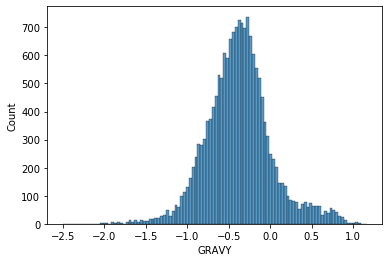

In [5]:
# Get uniprot_ids and sequence from the database and calculate the GRAVY's

query = "SELECT uniprot_id, sequence FROM protein"
uniprot_seq = pd.read_sql(query, conn)
uniprot_seq = uniprot_seq[~uniprot_seq.sequence.isna()]
uniprot_seq["GRAVY"] = uniprot_seq.apply(lambda x: calculateGravy(x["sequence"]), axis = 1)
sns.histplot(uniprot_seq.GRAVY)
uniprot_seq.head()

In [6]:
uniprot_seq = uniprot_seq.filter(items = ["uniprot_id", "GRAVY"])

In [7]:
# Read expression matrix

data = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
data= pd.pivot_table(data, values = "NSAF", index = "assay_id", columns = 'uniprot_id')
data_nsaf = pd.read_csv("../preprocessing/NSAF_50.csv", index_col = "assay_id")
data=data.loc[data_nsaf.index]
# Get metadata of the samples

meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0] if x in groups.cell_line.unique() else x)
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [165]:
meta.experiment_type.unique()

array(['in-solution', 'FASP', 'in-gel', 'in-solution, FASP',
       'in-gel, in-solution'], dtype=object)

In [8]:
meta.loc[(meta.PXD_accession.isin(["PXD003406", "PXD003407"])) & (meta.pool_id == 0), "experiment_type"] = "in-solution"
meta.loc[(meta.PXD_accession.isin(["PXD003406", "PXD003407"])) & (meta.pool_id != 0), "experiment_type"] = "in-gel"

In [9]:
is_assays = meta[meta.experiment_type == "in-solution"].index
fasp_assays = meta[meta.experiment_type == "FASP"].index
gel_assays = meta[meta.experiment_type == "in-gel"].index

In [10]:
uniprot_ids = uniprot_seq["uniprot_id"].tolist()
GRAVYs = uniprot_seq["GRAVY"].tolist()

uni_gravy = {uniprot_ids[x]:GRAVYs[x] for x in range(len(uniprot_ids))}

In [11]:
def apply_gravy(row):
    column_names = data.columns
    score = 0
    norm = 0

    for i in range(1,len(column_names)-1):
        
        saf = row.values[i]
        prot = column_names[i]

        if saf != 0.0 and prot in list(uniprot_seq.uniprot_id): 
            
            GRAVY = uni_gravy[prot] #Take GRAVY score from uniprot_seq table
            score += saf*GRAVY #Update score so there is one complete hydrophobicity score for the proteome
            norm += saf

    # Scores are normalized by the total expression in a sample to get the 'mean hydrophobicity score' of a sample    
    norm_score = score/norm

    print("returned")

    return norm_score

In [12]:
proteins_per_sample = data.notna().sum(axis=1)

In [13]:
data=data.fillna(0)

In [14]:
column_names = data.columns

In [ ]:
GRAVY_df = []
count=0
for row in data.to_numpy():
    count+=1
    print(count)
    GRAVY_row = []
    for i, value in enumerate(row):
        GRAVY_row.append(uni_gravy[column_names[i]]*value)
    GRAVY_df.append(GRAVY_row)

In [17]:
import json
with open("/home/compomics/Sam/git/python/master_thesis/Atlas_analysis/ML/GO_C_uniprot_map.json", 'r') as f:
    uniprot_go_compartment = json.load(f)


In [ ]:
comp_data = data.loc[:, annotated_prots]

In [25]:
GO_description = pd.read_csv("../annotation_files/go_description.txt", sep="\t", index_col="GO_ID")

In [79]:
GO_description.loc[membrane_go]

,Description,annotation_class,annotation_label
GO_ID,,,
GO:0005886,The membrane surrounding a cell that separates...,GO:0005886,plasma membrane


In [82]:
# nucleus
nucleus = 'GO:0005634'

# cytosol
cytosol = "GO:0005829"

In [98]:
def get_percentage_compartment(ontology_term, name):

    membrane_composition = []
    count=0
    for row in comp_data.to_numpy():
        count+=1

        mp = 0
        proteins=0
        for i, value in enumerate(row):
            if value==0:
                continue
            
            proteins +=1
            protein = annotated_prots[i]
            flag=False
            gos = uniprot_go_compartment[protein]
            if ontology_term in gos:
                mp += 1
        membrane_composition.append(mp/proteins)
    membrane_representation = pd.Series(membrane_composition, index=data.index)
    membrane_representation.name = name
    sns.boxplot(data=pd.merge(pd.DataFrame(membrane_representation.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index]), 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), y="experiment_type", x=name,
                            saturation=.7, order=["in-gel", "in-solution", "FASP"], orient = "h")
    sns.stripplot(data=pd.merge(pd.DataFrame(membrane_representation.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index]), 
                                meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), y="experiment_type", x=name,
                                alpha=.5, order=["in-gel", "in-solution", "FASP"])
    
    plt.ylabel("Sample preparation")
    return membrane_representation

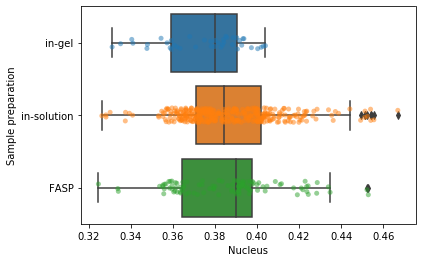

In [95]:
get_percentage_compartment(nucleus, "Nucleus")

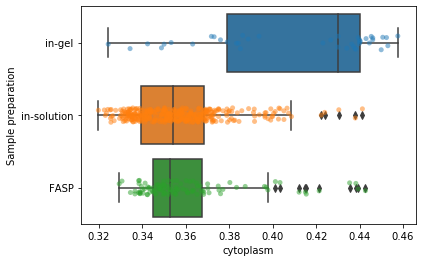

In [96]:
get_percentage_compartment("GO:0005737", "cytoplasm")

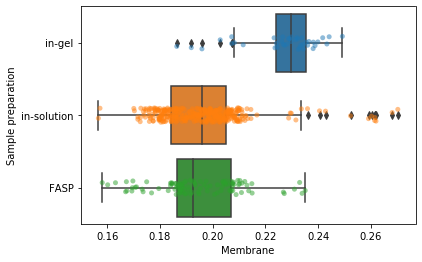

In [99]:
membrane = "GO:0005886"
mr = get_percentage_compartment(membrane, "Membrane")

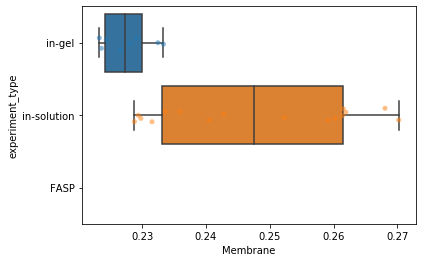

In [116]:
sns.boxplot(data=pd.merge(pd.DataFrame(mr.loc[meta.PXD_accession.isin(["PXD003406", "PXD003407"]).index]), 
                            meta[meta.PXD_accession.isin(["PXD003406", "PXD003407"])], left_index=True, right_index=True), y="experiment_type", x="Membrane",
                            saturation=.7, order=["in-gel", "in-solution", "FASP"], orient = "h")
sns.stripplot(data=pd.merge(pd.DataFrame(mr.loc[meta.PXD_accession.isin(["PXD003406", "PXD003407"]).index]), 
                                meta[meta.PXD_accession.isin(["PXD003406", "PXD003407"])], left_index=True, right_index=True), y="experiment_type", x="Membrane",
                                alpha=.5, order=["in-gel", "in-solution", "FASP"])
    

In [174]:
GRAVY_df = pd.DataFrame(GRAVY_df, index=data.index)

In [ ]:
sns.scatterplot(x=(data==0.0).sum(axis=1),y=GRAVY_df.sum(axis=1))

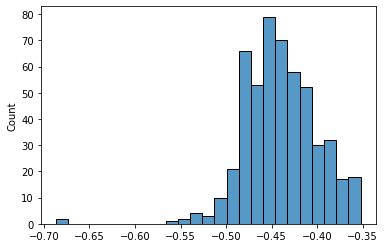

In [175]:
sns.histplot(GRAVY_df.sum(axis=1))

In [ ]:
data["GRAVY"] = data.fillna(0).apply(lambda x: apply_gravy(x), axis = 1)

# On protein level

In [176]:
meta.experiment_type.value_counts()

in-solution            355
FASP                   105
in-gel                  41
in-gel, in-solution     13
in-solution, FASP        4
Name: experiment_type, dtype: int64

In [177]:
data_gravy = GRAVY_df.sum(axis=1) # NSAF sums to 1 for each sample
data_gravy.name = "GRAVY"

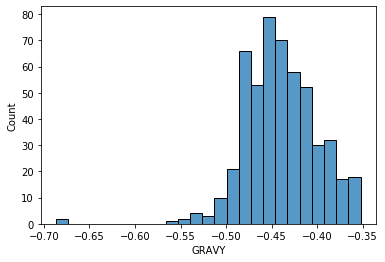

In [178]:
sns.histplot(data_gravy)

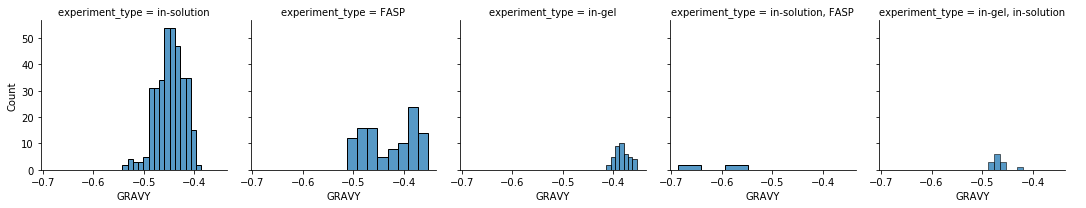

In [179]:
# Plot the same as above but separately for each experiment type

# Form a facetgrid using columns with a hue
sea = sns.FacetGrid(pd.merge(data_gravy, meta, left_index=True, right_index=True), col = "experiment_type")
   
# map the above form facetgrid with some attributes  
sea.map(sns.histplot, "GRAVY")
 
# adding legend
sea.add_legend()

In [180]:
data_gravy.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index]

assay_id
30960   -0.411268
30961   -0.412426
31008   -0.407763
31009   -0.407618
31102   -0.455003
           ...   
36558   -0.481228
36563   -0.464266
36568   -0.469787
36573   -0.442322
36578   -0.442418
Name: GRAVY, Length: 501, dtype: float64

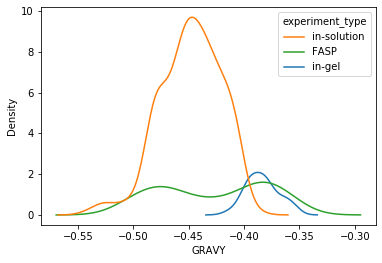

In [181]:
sns.kdeplot(data = pd.merge(data_gravy.loc[meta[meta.experiment_type.isin(["in-gel", "FASP", "in-solution"])].index], 
                            meta[meta.experiment_type.isin(["in-gel", "FASP", "in-solution"])], left_index=True, right_index=True), x = "GRAVY", hue = "experiment_type", common_norm=True,
                            palette=[sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0]])

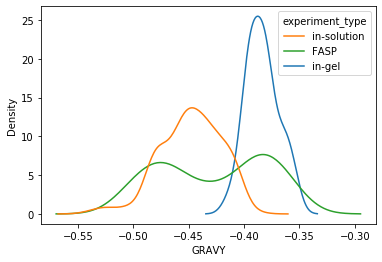

In [182]:
sns.kdeplot(data = pd.merge(data_gravy.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), x = "GRAVY", hue = "experiment_type", common_norm=False,
                            palette=[sns.color_palette()[1],sns.color_palette()[2],sns.color_palette()[0]])

In [183]:
pd.merge(data_gravy.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True
                            , right_index=True)["experiment_type"].value_counts()

in-solution    355
FASP           105
in-gel          41
Name: experiment_type, dtype: int64

Text(0, 0.5, 'Sample preparation')

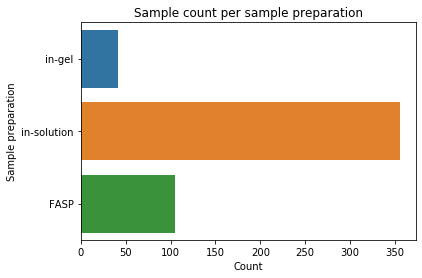

In [157]:
sns.barplot(x=[41,355,105], y=["in-gel", "in-solution", "FASP"])
plt.title("Sample count per sample preparation")
plt.xlabel("Count")
plt.ylabel('Sample preparation')

In [184]:
meta.groupby("experiment_type").nunique()["PXD_accession Group".split()]

,PXD_accession,Group
experiment_type,,
FASP,11,8
in-gel,6,7
"in-gel, in-solution",2,2
in-solution,25,14
"in-solution, FASP",1,1


Text(0, 0.5, 'Sample preparation')

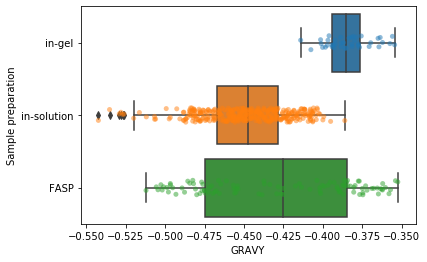

In [185]:
sns.boxplot(data=pd.merge(data_gravy.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), y="experiment_type", x="GRAVY",
                            saturation=.7, order=["in-gel", "in-solution", "FASP"], orient = "h")
sns.stripplot(data=pd.merge(data_gravy.loc[meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])].index], 
                            meta[meta.experiment_type.isin(["in-solution", "FASP", "in-gel"])], left_index=True, right_index=True), y="experiment_type", x="GRAVY",
                            alpha=.5, order=["in-gel", "in-solution", "FASP"])
plt.ylabel("Sample preparation")

In [ ]:
sns.color_palette()[:3]

In [ ]:
sns.color_palette()[:3][::-1]

In [186]:
on_filter_index = meta[meta.experiment_type == "FASP"].index
in_solution_index = meta[meta.experiment_type == "in-solution"].index
in_gel_index = meta[meta.experiment_type == "in-gel"].index

In [187]:
from scipy import stats


filter_vs_solution = stats.ttest_ind(data_gravy.loc[on_filter_index], data_gravy.loc[in_solution_index], equal_var = False)[1]
filter_vs_gel = stats.ttest_ind(data_gravy.loc[on_filter_index], data_gravy.loc[in_gel_index], equal_var = False)[1]
gel_vs_solution = stats.ttest_ind(data_gravy.loc[in_gel_index], data_gravy.loc[in_solution_index], equal_var = False)[1]

print("Welch test, parametric unequal variance")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

filter_vs_solution = stats.mannwhitneyu(data_gravy.loc[on_filter_index], data_gravy.loc[in_solution_index])[1]
filter_vs_gel = stats.mannwhitneyu(data_gravy.loc[on_filter_index], data_gravy.loc[in_gel_index])[1]
gel_vs_solution = stats.mannwhitneyu(data_gravy.loc[in_gel_index], data_gravy.loc[in_solution_index])[1]

print("Mann whitney test (non parametric)")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))


filter_vs_solution = stats.kruskal(data_gravy.loc[on_filter_index], data_gravy.loc[in_solution_index])[1]
filter_vs_gel = stats.kruskal(data_gravy.loc[on_filter_index], data_gravy.loc[in_gel_index])[1]
gel_vs_solution = stats.kruskal(data_gravy.loc[in_gel_index], data_gravy.loc[in_solution_index])[1]

print("Kruskal wallis test (non parametric)")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

# TODO: perform other tests (Kruskal Wallis)

Welch test, parametric unequal variance
Filter vs solution:  6.285388216628615e-05
Filter vs gel:       5.854505296607415e-14
gel vs solution:     2.512397782156395e-38
Mann whitney test (non parametric)
Filter vs solution:  0.00012518722123014167
Filter vs gel:       3.155544418583915e-06
gel vs solution:     1.9434328425863252e-25
Kruskal wallis test (non parametric)
Filter vs solution:  0.00024996630362811637
Filter vs gel:       6.246557132476075e-06
gel vs solution:     3.857702527598011e-25


In [188]:
solution_gel = pd.concat([data_gravy[(meta.PXD_accession.isin(["PXD003406","PXD003407"])) & (meta.experiment_type=="in-gel")],
           data_gravy[(meta.PXD_accession.isin(["PXD003406","PXD003407"])) & (meta.experiment_type=="in-solution")]])
annot =  ["in-gel"] * len(data_gravy[(meta.PXD_accession.isin(["PXD003406","PXD003407"])) & (meta.experiment_type=="in-gel")])
annot += ["in-solution"] * len(data_gravy[(meta.PXD_accession.isin(["PXD003406","PXD003407"])) & (meta.experiment_type=="in-solution")])
solution_gel = solution_gel.reset_index()
solution_gel["experiment_type"] = annot

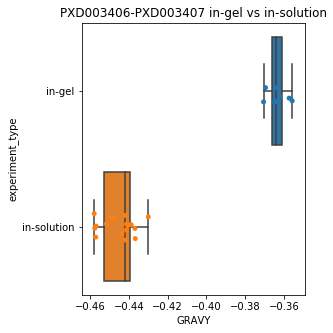

In [189]:
plt.figure(figsize=(4,5))
plt.title("PXD003406-PXD003407 in-gel vs in-solution")
sns.boxplot(data=solution_gel, x="GRAVY", y="experiment_type")
sns.stripplot(data=solution_gel, x="GRAVY", y="experiment_type")

# On peptide level

In [ ]:
meta = pd.read_csv("../../Metadata/unified_metadata.csv")

In [ ]:
no_pool = meta[meta.pool_id.isin([0])].assay_id.tolist()
pools = meta[~meta.assay_id.isin(no_pool)].groupby(["PXD_accession", "pool_id"]).apply(lambda x: list(x.assay_id)).tolist()

In [ ]:
print("Unpooled")
meta.experiment_type.value_counts()

In [ ]:
meta2 = pd.read_csv("../../Metadata/unified_metadata.csv")
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index="assay_id", columns="uniprot_id", values = "NSAF")

meta2 = meta2[meta2.assay_id.isin(nsaf.index)]

In [ ]:
# Pooled
meta2.groupby("experiment_type").count()

In [ ]:
# Get the peptide counts for each assays and information of the peptides (sequence)

sql_query = "SELECT assay_id, peptide_id, quantification FROM peptide_to_assay"
peptide_assay = pd.read_sql(sql_query, conn)

sql_query = "SELECT * FROM peptide"
peptides = pd.read_sql(sql_query, conn)

In [ ]:
# Calculate some attributes
peptides["GRAVY"] = peptides.peptide_sequence.apply(lambda x: calculateGravy(x))
peptides["MolWeight"] = peptides.peptide_sequence.apply(lambda x: calculateWeight(x))
peptides["Length"] = peptides.peptide_sequence.apply(lambda x: len(x))

In [ ]:
peptides.loc[:,:]

In [ ]:
# Plot the attributes of peptides found in the database, regardless of the number of times they are identified
fig, ax = plt.subplots(1,3, figsize=(30,7))

fig.suptitle("Distribution of all identified peptides in the database")
ax[0].set_title("Hydrophobicity")
ax[1].set_title("Molecular weight")
ax[2].set_title("Length")

sns.kdeplot(peptides.GRAVY, ax=ax[0])
sns.kdeplot(peptides.MolWeight, ax=ax[1])
sns.histplot(peptides.Length, ax=ax[2])

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(20,7))

fig.suptitle("Distribution of all identified peptides in the database")
ax[0].set_title("Hydrophobicity vs molecular weight")
ax[1].set_title("Hydrophobicity vs sequence length")

sns.scatterplot(data=peptides, x="GRAVY", y="MolWeight", ax=ax[0])
sns.scatterplot(data=peptides, x="GRAVY", y="Length", ax=ax[1])

In [ ]:
peptide_table = pd.merge(peptide_assay, peptides, on = "peptide_id")

In [ ]:
# Peptides identified in the MS-files
meta.peptides

In [ ]:
# NOTE: the low peptide identifications is due to fractions
sns.kdeplot(meta.peptides, hue = meta["ionbot_version"])

In [ ]:
FASP_assay = meta[(meta.experiment_type == "FASP")].assay_id.tolist()
ingel_assay = meta[(meta.experiment_type == "in-gel")].assay_id.tolist()
in_solution_assay = meta[(meta.experiment_type == "in-solution")].assay_id.tolist()

In [ ]:
peptide_table

In [ ]:
peptide_table[peptide_table.peptide_id == 110730450]

In [ ]:
# Distribution of peptide GRAVY scores identified with each sample prep workflow
FASP_peptides = peptide_table[peptide_table.assay_id.isin(FASP_assay)].peptide_id.unique()
ingel_peptides = peptide_table[peptide_table.assay_id.isin(ingel_assay)].peptide_id.unique()
in_solution_peptides = peptide_table[peptide_table.assay_id.isin(in_solution_assay)].peptide_id.unique()

In [ ]:
FASP_GRAVY = peptide_table[peptide_table.peptide_id.isin(FASP_peptides)].drop_duplicates(["peptide_id"]).GRAVY
ingel_GRAVY = peptide_table[peptide_table.peptide_id.isin(ingel_peptides)].drop_duplicates(["peptide_id"]).GRAVY
insolution_GRAVY = peptide_table[peptide_table.peptide_id.isin(in_solution_peptides)].drop_duplicates(["peptide_id"]).GRAVY

In [ ]:
sns.kdeplot(x=FASP_GRAVY)
sns.kdeplot(x=ingel_GRAVY)
sns.kdeplot(x=insolution_GRAVY)

In [ ]:
# Counts of samples with certain sample prep (including each fraction as a count)
plt.bar(x=["On Filter", 'In Gel', "In Solution"], height = [len(set(FASP_assay)), len(set(ingel_assay)), len(set(in_solution_assay))])

In [ ]:
# Counts of samples with certain sample prep
plt.bar(x=["On Filter", 'In Gel', "In Solution"], height = [len(set(FASP_assay)), len(set(ingel_assay)), len(set(in_solution_assay))])

In [ ]:
peptide_table.assay_id.nunique()

In [ ]:
meta.assay_id.nunique()

In [ ]:
peptides_FASP = peptide_table[peptide_table.assay_id.isin(FASP_assay)]
peptides_ingel = peptide_table[peptide_table.assay_id.isin(ingel_assay)]
peptides_solution = peptide_table[peptide_table.assay_id.isin(in_solution_assay)]

In [ ]:
from ipywidgets import IntProgress
from IPython.display import display

In [ ]:
def summarize_assay_datapoints(table: pd.DataFrame):
    
    # {'GRAVY': {'assay1': x, 'assay2': x}, {'MolWeight}: {'assay1': x, 'assay2': x}}
    dataframe_data = {'GRAVY': {}, 
                      'MolWeight': {},
                      'AvgLength': {}}
    
    assay_ids = table.assay_id.unique()

    f = IntProgress(min=0, max = len(assay_ids))
    display(f)

    # For each assay, compute several metrics
    for assay_id in assay_ids:
        assay_table = table[table.assay_id == assay_id]

        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0

        # For each peptide in the assay, sum the metrics
        for i, row in assay_table.iterrows():

            total_quant += row["quantification"]
            Gravy += row["GRAVY"] * row["quantification"]
            MolWeight += row["MolWeight"] * row["quantification"]
            AvgLength += row["Length"] * row["quantification"]

        # Normalize them by the amount of peptides identified
        Gravy = Gravy / total_quant
        MolWeight = MolWeight / total_quant
        AvgLength = AvgLength / total_quant

        # Save them in dataframe format
        dataframe_data["GRAVY"][assay_id] = Gravy
        dataframe_data["MolWeight"][assay_id] = MolWeight
        dataframe_data["AvgLength"][assay_id] = AvgLength

        f.value += 1
    
    return pd.DataFrame(dataframe_data)

In [ ]:
# Edit to pool samples because fractionation is based on physicochemical properties such as hydrophobicity
def summarize_assay_datapoints(table: pd.DataFrame):
    
    # {'GRAVY': {'assay1': x, 'assay2': x}, {'MolWeight}: {'assay1': x, 'assay2': x}}
    dataframe_data = {'GRAVY': {}, 
                      'MolWeight': {},
                      'AvgLength': {}}
    
    assay_ids = table.assay_id.unique()

    f = IntProgress(min=0, max = len(assay_ids))
    display(f)

    # For each assay, compute several metrics
    
    # For all pooled samples
    for pool_ids in pools:
        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0
        
        # For each fraction, compute the metrics and sum them across fractions
        for assay_id in pool_ids:
            
            if assay_id in table.assay_id.unique():
     
                assay_table = table[table.assay_id == assay_id]
                
                for i, row in assay_table.iterrows():

                    total_quant += row["quantification"]
                    Gravy += row["GRAVY"] * row["quantification"]
                    MolWeight += row["MolWeight"] * row["quantification"]
                    AvgLength += row["Length"] * row["quantification"]
                
                f.value += 1
    
        if Gravy != 0:

            Gravy = Gravy / total_quant
            MolWeight = MolWeight / total_quant
            AvgLength = AvgLength / total_quant

            dataframe_data["GRAVY"][assay_id] = Gravy
            dataframe_data["MolWeight"][assay_id] = MolWeight
            dataframe_data["AvgLength"][assay_id] = AvgLength


    for assay_id in no_pool:
        if assay_id not in table.assay_id.unique():
            continue
        
        assay_table = table[table.assay_id == assay_id]

        total_quant = 0
        Gravy = 0
        MolWeight = 0
        AvgLength = 0

        # For each peptide in the assay, sum the metrics
        for i, row in assay_table.iterrows():

            total_quant += row["quantification"]
            Gravy += row["GRAVY"] * row["quantification"]
            MolWeight += row["MolWeight"] * row["quantification"]
            AvgLength += row["Length"] * row["quantification"]

        # Normalize them by the amount of peptides identified
        Gravy = Gravy / total_quant
        MolWeight = MolWeight / total_quant
        AvgLength = AvgLength / total_quant

        # Save them in dataframe format
        dataframe_data["GRAVY"][assay_id] = Gravy
        dataframe_data["MolWeight"][assay_id] = MolWeight
        dataframe_data["AvgLength"][assay_id] = AvgLength

        f.value += 1
    
    return pd.DataFrame(dataframe_data)

In [ ]:
# Including all fractions
print(peptides_ingel.shape, peptides_solution.shape, peptides_FASP.shape)

In [ ]:
# Not all fractions
print(peptides_ingel.shape, peptides_solution.shape, peptides_FASP.shape)

In [151]:
in_gel_df = summarize_assay_datapoints(peptides_ingel)
in_solution_df = summarize_assay_datapoints(peptides_solution)
FASP_df = summarize_assay_datapoints(peptides_FASP)

IntProgress(value=0, max=300)

In [152]:
in_gel_df["Type"] = "in gel"
in_solution_df["Type"] = "in solution"
FASP_df["Type"] = "on filter"

In [153]:
summary_df = pd.concat([in_gel_df, in_solution_df, FASP_df])
summary_df.head()

,GRAVY,MolWeight,AvgLength,Type
31340,-0.198248,2265.553782,17.706977,in gel
31343,-0.200207,2258.596206,17.655382,in gel
31302,-0.103948,1988.904953,15.525331,in gel
31300,-0.102305,1981.819561,15.465924,in gel
31307,-0.222008,2207.295976,17.237629,in gel


In [ ]:
summary_df = pd.concat([in_gel_df, in_solution_df, FASP_df])
summary_df.head()

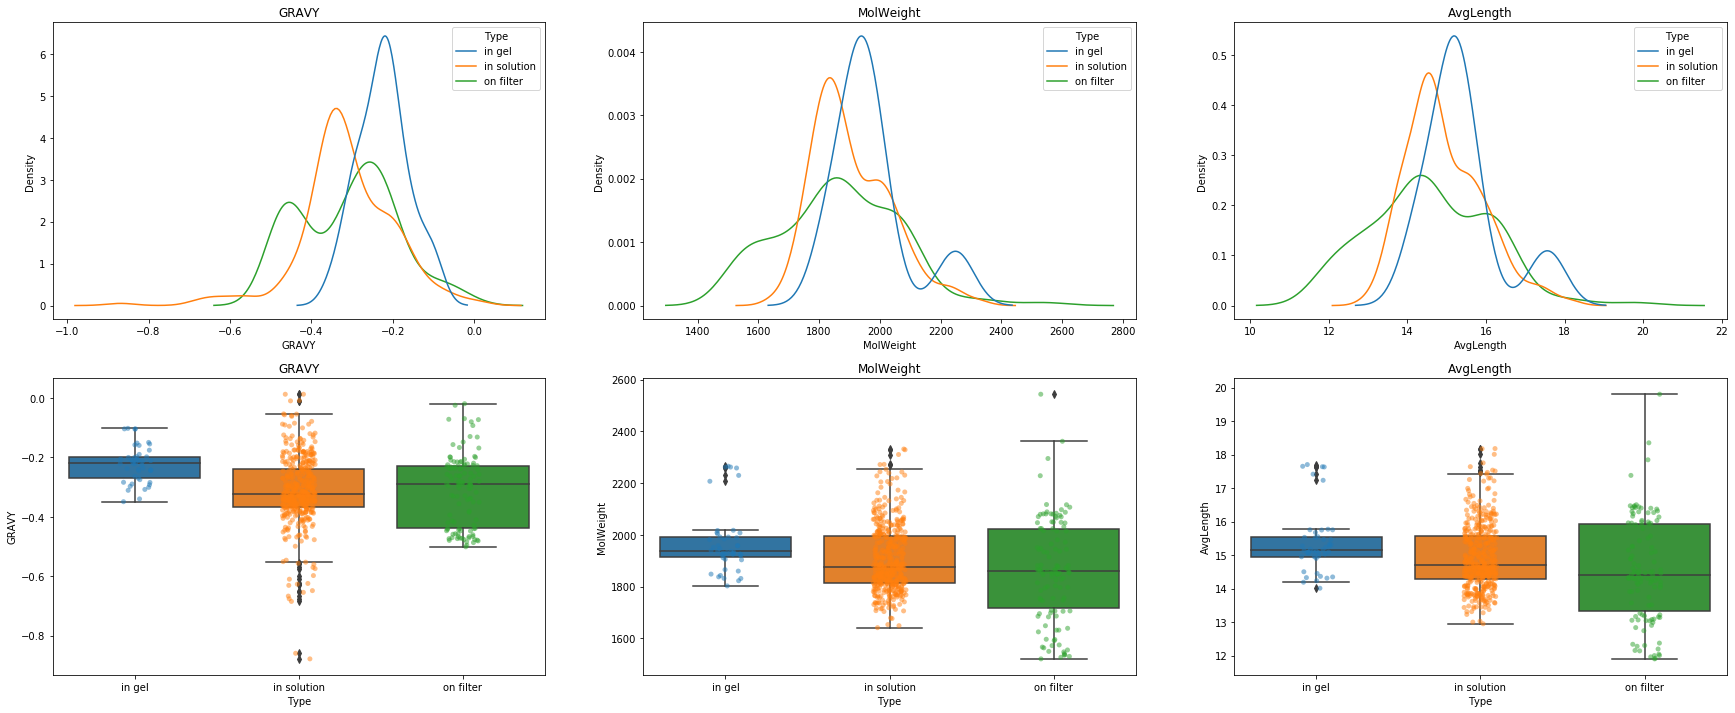

In [154]:
# Plot the mean GRAVY, molecular weight and length of the peptides identified in a sample

fig, ax = plt.subplots(2,3, figsize=(30,12))

ax[0,0].set_title("GRAVY")
sns.kdeplot(summary_df.GRAVY, hue = summary_df.Type, ax = ax[0,0], common_norm=False)

ax[0,1].set_title("MolWeight")
sns.kdeplot(summary_df.MolWeight, hue = summary_df.Type, ax = ax[0,1], common_norm=False)

ax[0,2].set_title("AvgLength")
sns.kdeplot(summary_df.AvgLength, hue = summary_df.Type, ax = ax[0,2], common_norm=False)

ax[1,0].set_title("GRAVY")
sns.boxplot(data=summary_df, x="Type", y="GRAVY", ax=ax[1,0])
sns.stripplot(data=summary_df, x="Type", y="GRAVY", ax=ax[1,0], alpha=.5)

ax[1,1].set_title("MolWeight")
sns.boxplot(data=summary_df, x="Type", y="MolWeight", ax=ax[1,1])
sns.stripplot(data=summary_df, x="Type", y="MolWeight", ax=ax[1,1], alpha=.5)

ax[1,2].set_title("AvgLength")
sns.boxplot(data=summary_df, x="Type", y="AvgLength", ax=ax[1,2])
sns.stripplot(data=summary_df, x="Type", y="AvgLength", ax=ax[1,2], alpha=.5)

In [155]:
from scipy import stats

In [190]:
filter_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in solution"].GRAVY, summary_df[summary_df.Type == "on filter"].GRAVY)[1]
filter_vs_gel = stats.kruskal(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "on filter"].GRAVY)[1]
gel_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "in solution"].GRAVY)[1]

print("Kruskal wallis test (non parametric) GRAVY")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

filter_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in solution"].MolWeight, summary_df[summary_df.Type == "on filter"].MolWeight)[1]
filter_vs_gel = stats.kruskal(summary_df[summary_df.Type == "in gel"].MolWeight, summary_df[summary_df.Type == "on filter"].MolWeight)[1]
gel_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in gel"].MolWeight, summary_df[summary_df.Type == "in solution"].MolWeight)[1]

print("Kruskal wallis test (non parametric) Weight")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

filter_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in solution"].AvgLength, summary_df[summary_df.Type == "on filter"].AvgLength)[1]
filter_vs_gel = stats.kruskal(summary_df[summary_df.Type == "in gel"].AvgLength, summary_df[summary_df.Type == "on filter"].AvgLength)[1]
gel_vs_solution = stats.kruskal(summary_df[summary_df.Type == "in gel"].AvgLength, summary_df[summary_df.Type == "in solution"].AvgLength)[1]

print("Kruskal wallis test (non parametric) Length")
print("Filter vs solution:  {}".format(filter_vs_solution))
print("Filter vs gel:       {}".format(filter_vs_gel))
print("gel vs solution:     {}".format(gel_vs_solution))

Kruskal wallis test (non parametric) GRAVY
Filter vs solution:  0.8768486850806904
Filter vs gel:       4.668417495118764e-06
gel vs solution:     1.9583377256871726e-09
Kruskal wallis test (non parametric) Weight
Filter vs solution:  0.04361587142261304
Filter vs gel:       0.001486898088740055
gel vs solution:     0.0009931716710042452
Kruskal wallis test (non parametric) Length
Filter vs solution:  0.004365589918855636
Filter vs gel:       0.0006460786366630909
gel vs solution:     0.003775378627146875


In [ ]:
from scipy import stats
print(stats.ttest_ind(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "on filter"].GRAVY),
      stats.ttest_ind(summary_df[summary_df.Type == "in gel"].GRAVY, summary_df[summary_df.Type == "in solution"].GRAVY))

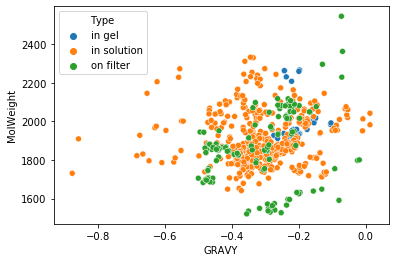

In [191]:
sns.scatterplot(x=summary_df.GRAVY, y=summary_df.MolWeight, hue = summary_df.Type)